In [5]:
!pwd

/content


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [0]:
class MNIST(Dataset):
    def __init__(self, X, y=None, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return len(self.X.index)
    
    def __getitem__(self, index):
        image = self.X.iloc[index, ].values.astype(np.uint8).reshape((28, 28, 1))
        
        if self.transform is not None:
            image = self.transform(image)
            
        if self.y is not None:
            return image, self.y.iloc[index]
        else:
            return image

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
%matplotlib inline

In [10]:
train_df = pd.read_csv('./sample_data/mnist_train_small.csv')
test_df = pd.read_csv('./sample_data/mnist_test.csv')

print('train data shape : ', train_df.shape)
print('test data shape : ', test_df.shape)

train data shape :  (19999, 785)
test data shape :  (9999, 785)


In [11]:
X_train, X_valid, y_train, y_valid = \
    train_test_split(train_df.iloc[:, 1:], train_df.iloc[:,0], test_size=1/10, random_state=42)

X_test, XY_test = test_df.iloc[:, 1:],test_df.iloc[:, 0]

print('train image shape : ', X_train.shape)
print('train label shape : ', y_train.shape)
print('valid image shape : ', X_valid.shape)
print('valid label image : ', y_valid.shape)
print('test image shape  : ', X_test.shape)
print('test image shape  : ', XY_test.shape)

train image shape :  (17999, 784)
train label shape :  (17999,)
valid image shape :  (2000, 784)
valid label image :  (2000,)
test image shape  :  (9999, 784)
test image shape  :  (9999,)


In [0]:
transform=transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

train_dataset = MNIST(X=X_train, y=y_train, transform=transform)
valid_dataset = MNIST(X=X_valid, y=y_valid, transform=transforms.ToTensor())
test_dataset = MNIST(X=X_test, y= None, transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

In [13]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print('images shape on PyTroch : ', images.size())
print('labels shape on PyTroch : ', labels.size())

images shape on PyTroch :  torch.Size([128, 1, 28, 28])
labels shape on PyTroch :  torch.Size([128])


(-0.5, 151.5, 151.5, -0.5)

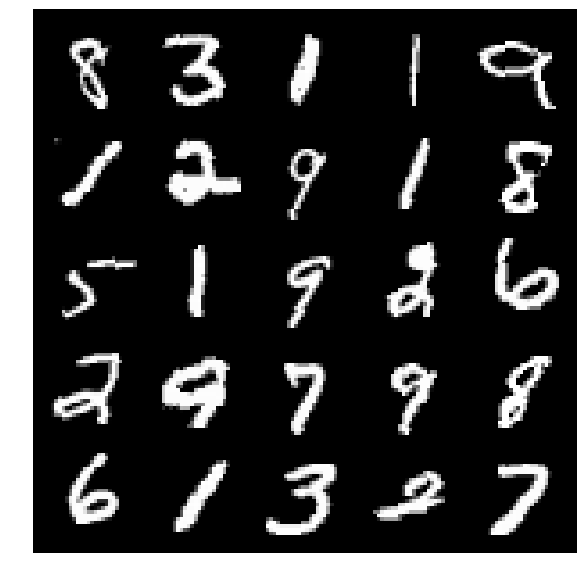

In [15]:
grid = make_grid(images[:25], nrow=5)

fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(grid.numpy().transpose((1, 2, 0)))
ax.axis('off')

In [0]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )
        
    def forward(self, x):
        # convert tensor (128, 1, 28, 28) --> (128, 1*28*28)
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x

In [17]:
model = MLP()
print(model)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)


In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [20]:
mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []
epochs = 50

for epoch in range(epochs):
    model.train()
    
    train_losses = []
    valid_losses = []
    for i, (images, labels) in enumerate(train_loader):
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        if (i * 128) % (128 * 100) == 0:
            print(f'{i * 128} / 50000')
            
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(valid_loader):
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            valid_losses.append(loss.item())
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
    mean_train_losses.append(np.mean(train_losses))
    mean_valid_losses.append(np.mean(valid_losses))
    
    accuracy = 100*correct/total
    valid_acc_list.append(accuracy)
    print('epoch : {}, train loss : {:.4f}, valid loss : {:.4f}, valid acc : {:.2f}%'\
         .format(epoch+1, np.mean(train_losses), np.mean(valid_losses), accuracy))

0 / 50000
12800 / 50000
epoch : 1, train loss : 0.3101, valid loss : 0.2853, valid acc : 92.30%
0 / 50000
12800 / 50000
epoch : 2, train loss : 0.2545, valid loss : 0.2555, valid acc : 92.80%
0 / 50000
12800 / 50000
epoch : 3, train loss : 0.2114, valid loss : 0.2214, valid acc : 93.60%
0 / 50000
12800 / 50000
epoch : 4, train loss : 0.1800, valid loss : 0.2061, valid acc : 94.30%
0 / 50000
12800 / 50000
epoch : 5, train loss : 0.1581, valid loss : 0.1796, valid acc : 95.20%
0 / 50000
12800 / 50000
epoch : 6, train loss : 0.1403, valid loss : 0.1728, valid acc : 95.10%
0 / 50000
12800 / 50000
epoch : 7, train loss : 0.1261, valid loss : 0.1613, valid acc : 95.10%
0 / 50000
12800 / 50000
epoch : 8, train loss : 0.1167, valid loss : 0.1569, valid acc : 95.50%
0 / 50000
12800 / 50000
epoch : 9, train loss : 0.1049, valid loss : 0.1421, valid acc : 95.70%
0 / 50000
12800 / 50000
epoch : 10, train loss : 0.0987, valid loss : 0.1374, valid acc : 95.70%
0 / 50000
12800 / 50000
epoch : 11, tra

KeyboardInterrupt: ignored

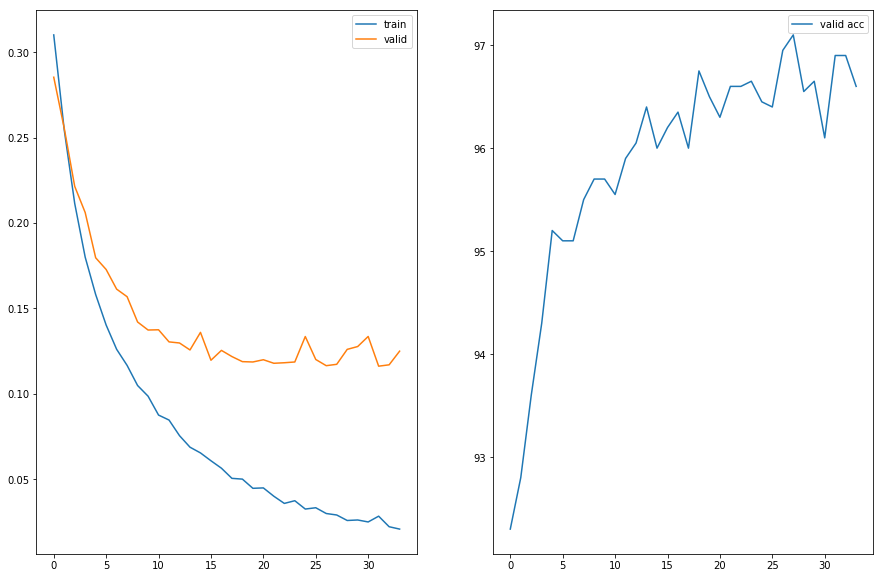

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax1.plot(mean_train_losses, label='train')
ax1.plot(mean_valid_losses, label='valid')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')

ax2.plot(valid_acc_list, label='valid acc')
ax2.legend()

In [22]:
import IPython
from google.colab import output
model.eval()

MLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [31]:
display(IPython.display.HTML('''
<table>
<td style="border-style: none;">
<div style="border: solid 2px #666; width: 143px; height: 144px;">
<canvas width="140" height="140"></canvas>
</div></td>
<td style="border-style: none;">
<button onclick="clear_value()">Clear</button>
<button onclick="set_value()">SET</button>

</td>
</table>

<script type="text/Javascript">
    var pixels = [];
    for (var i = 0; i < 28*28; i++) pixels[i] = 0;
    var click = 0;
    var a,b,c,d = 0
    var center_val = 20
    var side_val = 5
    var canvas = document.querySelector("canvas");
  
    canvas.addEventListener("mousemove", function(e){
        if (e.buttons == 1) {
            canvas.getContext("2d").fillStyle = "rgb(0,0,0)";
            canvas.getContext("2d").fillRect(e.offsetX, e.offsetY, 8, 8);
            x = Math.floor(e.offsetY * 0.2)
            y = Math.floor(e.offsetX * 0.2) + 1
            for (var dy = 0; dy < 2; dy++){
                for (var dx = 0; dx < 2; dx++){
                    if ((x + dx < 28) && (y + dy < 28)){
                        pixels[(y+dy)+(x+dx)*28] = center_val
                        pixels[(y+dy)+(x+dx)*28] = (a==0)*side_val+ (a==center_val)*center_val
                        pixels[(y+dy)+(x+dx)*28] = (b==0)*side_val + (b==center_val)*center_val
                        pixels[(y+dy)+(x+dx)*28] = (c==0)*side_val + (c==center_val)*center_val
                        pixels[(y+dy)+(x+dx)*28] = (d==0)*side_val + (d==center_val)*center_val
                    }
                }
            }
        } 
        
    });
    
    function set_value(){   
        var result = "[";
        for (var i = 0; i < 28*28; i++) result += pixels[i] + ",";
        result += "]";     
        google.colab.kernel.invokeFunction('notebook.AddListItem', [result], {});
    }
    
    function clear_value(){
        canvas.getContext("2d").fillStyle = "rgb(255,255,255)";
        canvas.getContext("2d").fillRect(0, 0, 140, 140);
        for (var i = 0; i < 28*28; i++) pixels[i] = 0;
      
      
    }
  
  
        
      
</script>
'''))

img_temp = []

def add_list_item(img):
  # Use redirect_to_element to direct the elements which are being written.
  global img_temp
  img_temp = img
   
output.register_callback('notebook.AddListItem', add_list_item)


In [44]:
image = np.array(eval(img_temp),dtype=np.float)
data_temp = torch.tensor(image,dtype=torch.float)
data_in = data_temp.view(1,-1)
outputs = model(data_in)
pred = outputs.max(1, keepdim=True)[1]
print(outputs)
print(pred)


tensor([[ 61.4075, -61.4366, -12.8163, -49.0960, -66.6653, -67.5734, -45.0381,
           4.1401, -28.9309,  11.4437]], grad_fn=<AddmmBackward>)
tensor([[0]])
